# Программирование на Python
## Семинар 8. Python для анализа данных
#### Задача 1
Вам дан массив данных, представленный в виде списка списков. Каждый вложенный список представляет собой измерение одного параметра для разных индивидуумов. В процессе обработки данных вам часто придется сталкиваться с тем, что параметры могут иметь разную шкалу. Существуют различные способы решения данной проблемы, среди которых - т. н. стандартизация, приводящее значения к стандартному нормальному распределению (большинство значений от -3 до 3). Формула выглядит следующим образом (в данном случае `x` - каждое значение, т. е. операцию ниже необходимо выполнить с каждым значением наших данных):

![standardization](https://i.ibb.co/THbWKqM/1-YSAAU-v-I8-Ol-HQz-G5-A1-Sg.png)

Напишите функцию, которая выполняет эту стандартизацию для двухмерного массива. При этом должна быть предусмотрена возможность осуществить это по строкам, по колонкам и для всего массива в целом.

Решите задачу в двух вариантах: 1) используя ТОЛЬКО встроенные средства Python и 2) с помощью `numpy`. Сравните эффективность двух подходов.

In [1]:
import numpy as np

# (псевдо)случайно генерируем матрицу 10 * 10000 из равномерного распределения с границами от -1000 до 1000
simulated_data = np.random.uniform(-1000, 1000, (10, 10000))
simulated_data_list = simulated_data.tolist()

**Python**

In [3]:
def mean(vector):
    return sum(vector) / len(vector)

def std(vector):
    vector_mean = mean(vector)
    vector_std = (sum((x - vector_mean) ** 2 for x in vector) / len(vector)) ** (1 / 2)

    return vector_std

def standardize1d(vector):
    vector_mean = mean(vector)
    vector_sd = std(vector)
    vector_std = [(x - vector_mean) / vector_sd for x in vector]

    return vector_std

def standardize(matrix):
    return [standardize1d(vector) for vector in matrix]

In [4]:
simulated_data_list_sd = standardize(simulated_data_list)

In [5]:
%%timeit
simulated_data_list_sd = standardize(simulated_data_list)

9.14 ms ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**NumPy**

In [10]:
simulated_data.shape

(10, 10000)

In [19]:
means.reshape((10, 1))

array([[-1.43913399],
       [-1.68804128],
       [-2.3430973 ],
       [-4.25161817],
       [ 8.19353825],
       [ 1.40415258],
       [-2.03019403],
       [ 0.57266179],
       [ 3.69349496],
       [-2.63235171]])

In [28]:
%%timeit
nrows = simulated_data.shape[0]

means = simulated_data.mean(axis=1).reshape((nrows, 1))
stds = simulated_data.std(axis=1).reshape((nrows, 1))

simulated_data_sd = (simulated_data - means) / stds

166 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


#### Задача 2
Используя средства numpy, проведите вычислительный эксперимент и выясните, можно ли считать статистически значимым результат проверки одной из выдвинутых на прошлом занятии гипотез.

**Data source:** https://www.kaggle.com/datasets/spscientist/students-performance-in-exams.

**Columns:**
- `gender` (binary variable);
- `race/ethnicity` (categorical variable);
- `parental level of education` (categorical variable, student's parents' level of education);
- `lunch` (categorical variable, quality of student's lunch);
- `test preparation course` (categorical variable, whether student managed to complete preparation course for the test);
- `math score` (numeric variable, score for Math test);
- `reading score` (numeric variable, score for Reading part);
- `writing score` (numeric variable, score for Writing part).

In [30]:
import csv
from collections import defaultdict

def group(vector, grouping):
    grouped = defaultdict(list)

    for value, key in zip(vector, grouping):
        grouped[key].append(value)

    return grouped

path = '../Занятие 1/StudentsPerformance.csv'
int_cols = ['math score', 'reading score', 'writing score']
data = defaultdict(list)

with open(path, mode='r', newline='') as file:
    csvfile = csv.DictReader(file, delimiter=',')

    for dct in csvfile:
        for key, value in dct.items():
            if key in int_cols:
                data[key].append(int(value))
            else:
                data[key].append(value)

In [32]:
grouped = group(data['writing score'], data['lunch'])

standard = np.array(grouped['standard'])
free = np.array(grouped['free/reduced'])

In [35]:
real_diff = standard.mean() - free.mean()
real_diff

7.800720602685885

In [ ]:
# H0: разницы на самом деле нет, а то, что мы видим - случайность

# насколько возможно встретить реальное значение разницы при условии, что "разницы на самом деле нет, а то, что мы видим - случайность"
#                                                        при условии, H0

# необходимо понять, какие вообще значения получаются при условии H0 -> найти распределение этих значений

# симулируем эксперимент:
#1 объединим два массива (standard и free)
#2 перемешаем все значения в получившемся массива случайным образом
#3 разделим на два массива изначальной формы
#4 посчитаем разность средних
#5 повторить много раз (N)

In [51]:
concat = np.concatenate((standard, free))
permuted = np.random.permutation(concat)
vector1_new, vector2_new = permuted[:standard.size], permuted[standard.size:]

In [54]:
def simulate(vector1, vector2):
    concat = np.concatenate((vector1, vector2))
    permuted = np.random.permutation(concat)
    vector1_new, vector2_new = permuted[:vector1.size], permuted[vector2.size:]
    simulated_diff = vector1_new.mean() - vector2_new.mean()
    
    return simulated_diff

In [55]:
N = 100000

simulated_diffs = np.array([simulate(standard, free) for i in range(N)])

In [56]:
simulated_diffs

array([-0.64341085,  0.19379845, -1.21860465, ..., -0.63875969,
       -0.24806202,  0.86976744])

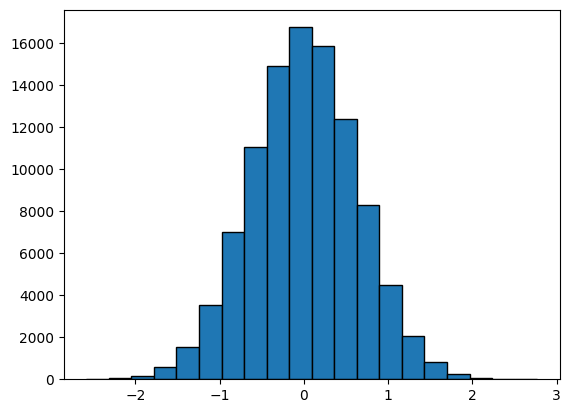

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(simulated_diffs, bins=20, edgecolor='black');

In [60]:
real_diff

7.800720602685885

In [ ]:
# H0: разницы на самом деле нет, а то, что мы видим - случайность

# РЕЗУЛЬТАТ: получить наблюдаемое значение при условии, что различия случайны, настолько маловероятно, что от гипотезы случайности
# придется отказаться

#### Задача 3
Сделайте данное вам ниже изображение черно-белым.

/var/folders/h6/lv17v1r10lz21g745pd6774h0tgc4z/T/ipykernel_5633/3783902954.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imread('./google_maps.png')


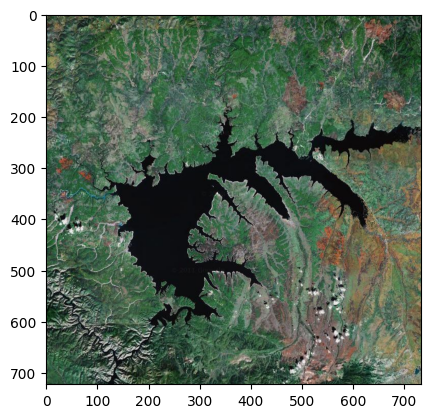

In [61]:
from imageio import imread
import matplotlib.pyplot as plt

img1 = imread('./google_maps.png')
plt.imshow(img1);

In [64]:
img1[0, 0, :]

array([45, 65, 37], dtype=uint8)

In [63]:
img1.shape

(723, 733, 3)

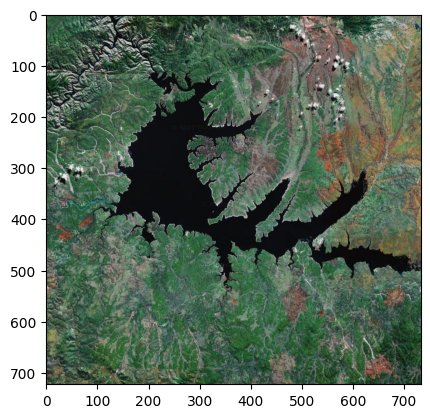

In [67]:
# отразить по вертикали
plt.imshow(img1[::-1, :, :]);

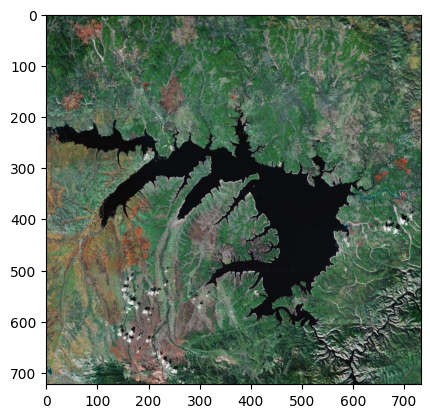

In [68]:
# отразить по горизонтали
plt.imshow(img1[:, ::-1, :]);

In [69]:
# необходимо для всех пикселей заменить значения rgb на средние по пикселю

img1[0, 0, :]

array([45, 65, 37], dtype=uint8)

In [70]:
img1.shape

(723, 733, 3)

In [78]:
means = img1.mean(axis=2).round().astype(int)
image_new = np.repeat(means.reshape((723, 733, 1)), 3, axis=2)

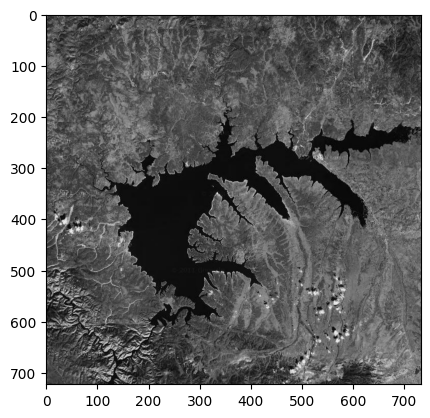

In [80]:
plt.imshow(image_new);

In [81]:
np.arange(9, 55, 3)

array([ 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54])

In [82]:
np.linspace(0, 1, 100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [84]:
means.flatten()

array([ 49,  80, 104, ..., 163, 150, 131])

In [86]:
standard.argmax()

67

In [87]:
standard.argmin()

45

In [89]:
np.argwhere((standard > 50) & (standard < 60))

array([[  6],
       [ 10],
       [ 14],
       [ 16],
       [ 28],
       [ 37],
       [ 39],
       [ 42],
       [ 72],
       [ 86],
       [ 91],
       [127],
       [137],
       [143],
       [152],
       [155],
       [162],
       [166],
       [192],
       [203],
       [215],
       [218],
       [228],
       [232],
       [234],
       [239],
       [241],
       [242],
       [243],
       [260],
       [263],
       [264],
       [285],
       [288],
       [317],
       [319],
       [325],
       [342],
       [344],
       [346],
       [349],
       [350],
       [353],
       [374],
       [376],
       [413],
       [423],
       [428],
       [450],
       [454],
       [456],
       [465],
       [479],
       [483],
       [497],
       [499],
       [502],
       [520],
       [522],
       [523],
       [530],
       [539],
       [541],
       [542],
       [546],
       [549],
       [559],
       [563],
       [572],
       [577],
       [589],
      

In [92]:
np.linalg.pinv(means)

array([[-2.38841497e-04,  7.40295514e-04,  2.26555108e-04, ...,
        -2.21637025e-05, -5.56891505e-05,  2.66664299e-04],
       [ 1.76250456e-03, -1.98224487e-03,  1.51534602e-03, ...,
        -2.39736131e-04,  3.54128758e-04, -6.12593160e-04],
       [-5.87070401e-05,  5.09927917e-04, -9.52701483e-04, ...,
         9.78887325e-05, -5.45427917e-04,  2.35731562e-04],
       ...,
       [-3.49740806e-03,  5.39375833e-03, -4.09351727e-03, ...,
         1.28929639e-04,  7.34644301e-04, -2.22114989e-04],
       [ 1.77102412e-03, -3.93519143e-03,  2.92584369e-03, ...,
        -6.13868673e-04,  4.47312298e-04,  6.55208033e-04],
       [-1.12491024e-03,  4.25231142e-03, -5.60934811e-03, ...,
         2.33232148e-04, -8.25817301e-04, -2.52050332e-04]])

In [91]:
np.linalg.inv(means)

LinAlgError: Last 2 dimensions of the array must be square

In [90]:
means

array([[ 49,  80, 104, ...,  48,  35,  50],
       [ 86,  72,  79, ...,  50,  44,  55],
       [ 77, 100,  97, ...,  36,  38,  63],
       ...,
       [ 77,  79,  73, ..., 125, 127, 134],
       [ 83,  83,  78, ..., 111, 128, 129],
       [ 84,  79,  89, ..., 163, 150, 131]])